# Connect Forest Management Model with Forest Carbon Budget Model (without calibration)

## Set up Modelling Environment

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import ws3.forest
import time
import gurobipy as grb
from util_opt import compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_maxstock, cbm_report, plugin_c_curves, compare_ws3_cbm, compile_events, compare_ws3_cbm_exactmatch
import pickle

In [2]:
#Start Calculating the Running Time
Start = time.time()

In [3]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
n_steps = 100
tvy_name = 'totvol'
case_study = 'redchris'

## Create and Run `ForestModel` instance

In [4]:
fm = ws3.forest.ForestModel(model_name='redchris',
                            # model_path='./data/woodstock_model_files_redchris',
                            model_path='./data/woodstock_model_files_redchris_test',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()

fm.grow()

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

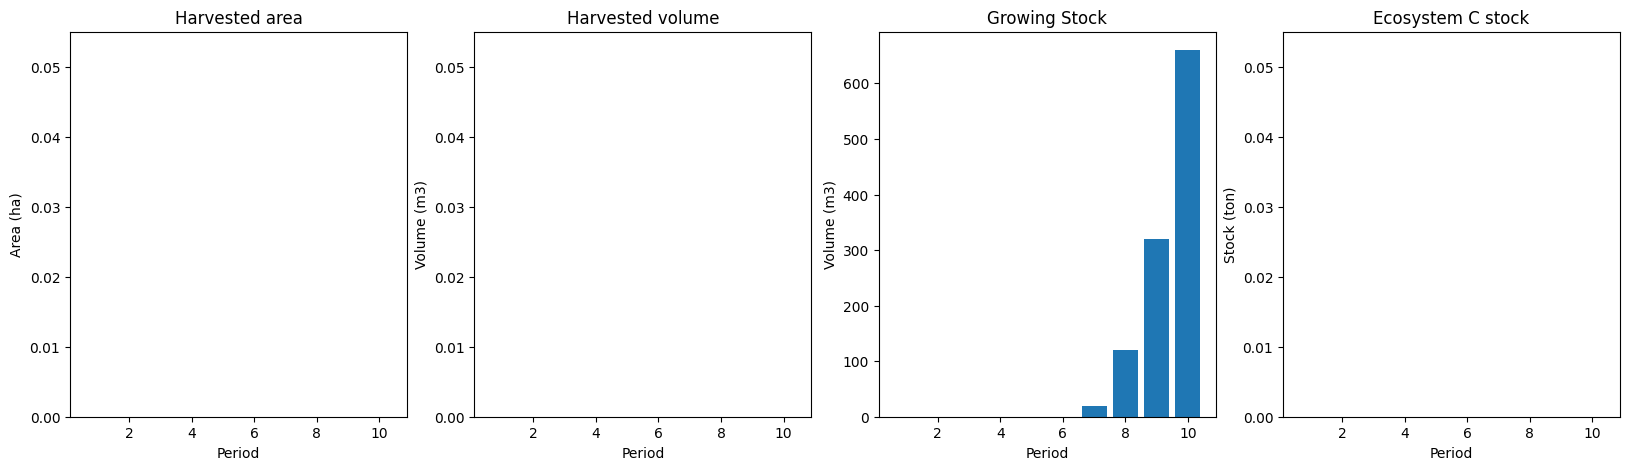

In [5]:
# Check the Forest Inventory of the Forest Model
df = compile_scenario_maxstock(fm)
plot_scenario_maxstock(df)

## Hard-link `ForestModel` to `libcbm`

Prepare CBM input files

In [6]:
# Define Disturance Types
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[5] == dtype_key[4] else 'harvest'

Here are other two ways to generate sit tables. But they are only suitbale for small forest model since they take too much running time and memory

In [7]:
sit_config, sit_tables = fm.to_cbm_sit(softwood_volume_yname='swdvol', 
                                       hardwood_volume_yname='hwdvol', 
                                       admin_boundary='British Columbia', 
                                       eco_boundary='Montane Cordillera',
                        disturbance_type_mapping=disturbance_type_mapping)

In [8]:
from libcbm.input.sit import sit_reader
from libcbm.input.sit import sit_cbm_factory 
from libcbm.model.cbm.cbm_output import CBMOutput
from libcbm.storage.backends import BackendType
from libcbm.model.cbm import cbm_simulator
sit_data = sit_reader.parse(sit_classifiers=sit_tables['sit_classifiers'],
                            sit_disturbance_types=sit_tables['sit_disturbance_types'],
                            sit_age_classes=sit_tables['sit_age_classes'],
                            sit_inventory=sit_tables['sit_inventory'],
                            sit_yield=sit_tables['sit_yield'],
                            sit_events=sit_tables['sit_events'],
                            sit_transitions=sit_tables['sit_transitions'],
                            sit_eligibilities=None)
sit = sit_cbm_factory.initialize_sit(sit_data=sit_data, config=sit_config)
classifiers, inventory = sit_cbm_factory.initialize_inventory(sit)
cbm_output = CBMOutput(classifier_map=sit.classifier_value_names,
                       disturbance_type_map=sit.disturbance_name_map)
with sit_cbm_factory.initialize_cbm(sit) as cbm:
    # Create a function to apply rule based disturbance events and transition rules based on the SIT input
    rule_based_processor = sit_cbm_factory.create_sit_rule_based_processor(sit, cbm)
    # The following line of code spins up the CBM inventory and runs it through 200 timesteps.
    cbm_simulator.simulate(cbm,
                           n_steps=n_steps,
                           classifiers=classifiers,
                           inventory=inventory,
                           pre_dynamics_func=rule_based_processor.pre_dynamics_func,
                           reporting_func=cbm_output.append_simulation_result,
                           backend_type=BackendType.numpy)
pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots','SoftwoodFineRoots',                        
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']
dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']

In [9]:
emissions_pools = ['CO2', 'CH4', 'CO', 'NO2']
ecosystem_pools = biomass_pools + dom_pools
# all_pools = biomass_pools + dom_pools + emissions_pools
all_pools = biomass_pools + dom_pools

In [10]:
# Define Time Steps
n_steps = fm.horizon * fm.period_length

# Run CBM and Generate CBM 0utputs
cbm_output = run_cbm_maxstock(sit_config, sit_tables, n_steps)

Emissions from all biomass components only resulting from fire disturbance, while these from all DOM pools resulting from annual decay processes and fire disturbance.

In [11]:
# Define Carbon Fluxes
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

npp_fluxes=[
    'DeltaBiomass_AG', 
    'DeltaBiomass_BG'
]

decay_emissions_fluxes = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

disturbance_production_fluxes = [
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction'   
]

disturbance_emissions_fluxes = [
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'   
]

all_fluxes = [
    'DisturbanceCO2Production',
    'DisturbanceCH4Production',
    'DisturbanceCOProduction',
    'DisturbanceBioCO2Emission',
    'DisturbanceBioCH4Emission',
    'DisturbanceBioCOEmission',
    'DecayDOMCO2Emission',
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir',
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceDOMCO2Emission',
    'DisturbanceDOMCH4Emission',
    'DisturbanceDOMCOEmission',
    'DisturbanceMerchLitterInput',
    'DisturbanceFolLitterInput',
    'DisturbanceOthLitterInput',
    'DisturbanceCoarseLitterInput',
    'DisturbanceFineLitterInput',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'
]
grossgrowth_ag = [
    "DeltaBiomass_AG",
    "TurnoverMerchLitterInput",
    "TurnoverFolLitterInput",
    "TurnoverOthLitterInput",
]

grossgrowth_bg = [
    "DeltaBiomass_BG",
    "TurnoverCoarseLitterInput",
    "TurnoverFineLitterInput",
]

product_flux = [
     "DisturbanceSoftProduction",
     "DisturbanceHardProduction",
     "DisturbanceDOMProduction",
]

GrossGrowth_AG = flux[[
        "DeltaBiomass_AG",
        "TurnoverMerchLitterInput",
        "TurnoverFolLitterInput",
        "TurnoverOthLitterInput",
        ]].sum(axis=1)

GrossGrowth_BG = flux[[
        "DeltaBiomass_BG",
        "TurnoverCoarseLitterInput",
        "TurnoverFineLitterInput",
        ]].sum(axis=1)

In [12]:
# Define Sum Carbon Pools and Sum Carbon Fluxes
pools = ecosystem_pools
fluxes = decay_emissions_fluxes + disturbance_emissions_fluxes
gross_growth = grossgrowth_ag + grossgrowth_bg

sum_pools = ['ecosystem', 'biomass', 'DOM']

,Biomass,DOM,Ecosystem,All_Emissions,Gross_Growth,Stock_Change
Year,,,,,,
0,0.062350,4039.717310,4039.779660,0.000000,0.000000,0.000000
1,0.139657,3952.015168,3952.154825,87.715628,0.090793,87.624835
2,0.269322,3869.896408,3870.165731,82.146062,0.156967,81.989095
3,0.466292,3792.618278,3793.084570,77.327235,0.246074,77.081160
4,0.745499,3719.626400,3720.371899,73.072764,0.360093,72.712671
...,...,...,...,...,...,...
96,1393.729165,2735.824581,4129.553746,76.196707,103.428831,-27.232124
97,1410.587302,2746.343824,4156.931126,76.845526,104.222906,-27.377380
98,1427.773077,2756.718212,4184.491289,77.463155,105.023317,-27.560163


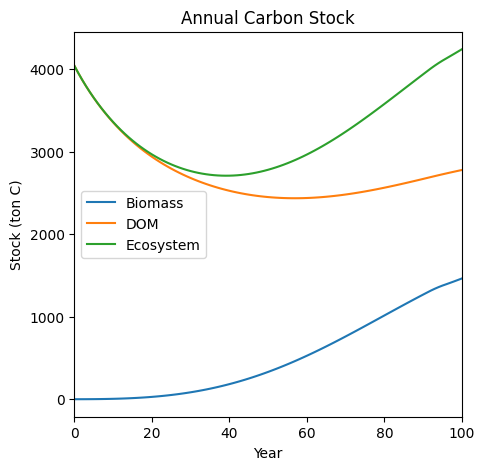

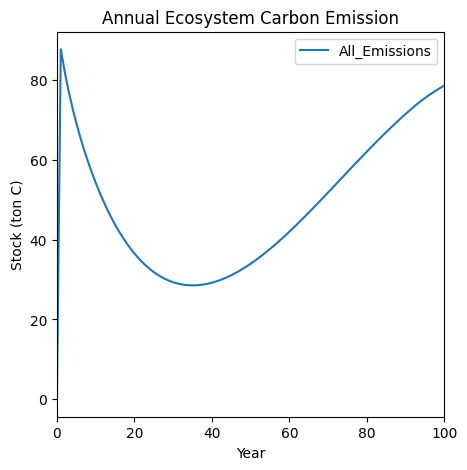

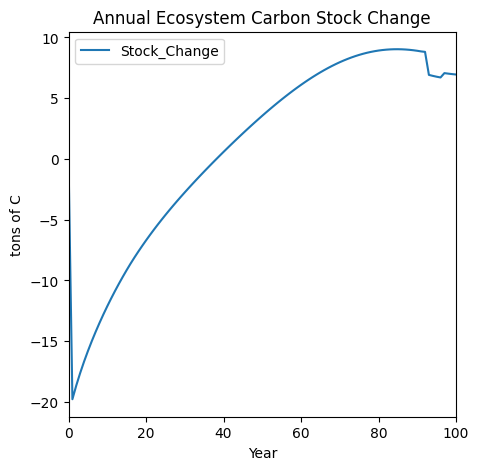

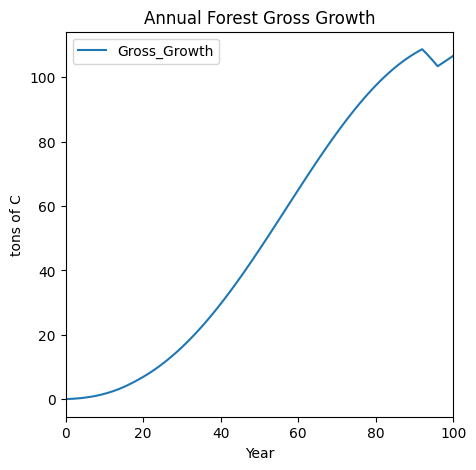

In [13]:
# Report Annual CBM Results
# cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)

## Generate and Add Carbon Yield Curves

In [14]:
sit_tables['sit_events']

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,min_softwood_age,max_softwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year


In [15]:
sit_tables['sit_inventory']

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa04,1,7,100,7,7,softwood,FALSE,1,10.0,0,0,fire,fire
1,tsa04,1,7,100,7,7,softwood,FALSE,2,10.0,0,0,fire,fire
2,tsa04,1,7,100,7,7,softwood,FALSE,3,10.0,0,0,fire,fire
3,tsa04,1,7,100,7,7,softwood,FALSE,4,10.0,0,0,fire,fire


In [16]:
sit_tables_sit_inventory = sit_tables['sit_inventory'].copy()

In [17]:
# Define Development Type Keys
sit_tables_sit_inventory['dtype_key'] = sit_tables_sit_inventory.apply(lambda r: '%s %s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4'], r['theme5']), axis=1)

In [18]:
sit_tables_sit_inventory

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance,dtype_key
0,tsa04,1,7,100,7,7,softwood,FALSE,1,10.0,0,0,fire,fire,tsa04 1 7 100 7 7
1,tsa04,1,7,100,7,7,softwood,FALSE,2,10.0,0,0,fire,fire,tsa04 1 7 100 7 7
2,tsa04,1,7,100,7,7,softwood,FALSE,3,10.0,0,0,fire,fire,tsa04 1 7 100 7 7
3,tsa04,1,7,100,7,7,softwood,FALSE,4,10.0,0,0,fire,fire,tsa04 1 7 100 7 7


In [19]:
timesteps = list(range(101))
sit_tables_sit_inventory_repeated = pd.concat([sit_tables_sit_inventory.assign(timestep=t) for t in timesteps], ignore_index=True)

In [20]:
sit_tables_sit_inventory_repeated

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance,dtype_key,timestep
0,tsa04,1,7,100,7,7,softwood,FALSE,1,10.0,0,0,fire,fire,tsa04 1 7 100 7 7,0
1,tsa04,1,7,100,7,7,softwood,FALSE,2,10.0,0,0,fire,fire,tsa04 1 7 100 7 7,0
2,tsa04,1,7,100,7,7,softwood,FALSE,3,10.0,0,0,fire,fire,tsa04 1 7 100 7 7,0
3,tsa04,1,7,100,7,7,softwood,FALSE,4,10.0,0,0,fire,fire,tsa04 1 7 100 7 7,0
4,tsa04,1,7,100,7,7,softwood,FALSE,1,10.0,0,0,fire,fire,tsa04 1 7 100 7 7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,tsa04,1,7,100,7,7,softwood,FALSE,4,10.0,0,0,fire,fire,tsa04 1 7 100 7 7,99
400,tsa04,1,7,100,7,7,softwood,FALSE,1,10.0,0,0,fire,fire,tsa04 1 7 100 7 7,100
401,tsa04,1,7,100,7,7,softwood,FALSE,2,10.0,0,0,fire,fire,tsa04 1 7 100 7 7,100
402,tsa04,1,7,100,7,7,softwood,FALSE,3,10.0,0,0,fire,fire,tsa04 1 7 100 7 7,100


In [21]:
# Assuming df is your dataframe
# grouped_sit_tables_sit_inventory = sit_tables['sit_inventory'].groupby('dtype_key')['area'].sum().reset_index()

# Rename the columns for clarity (optional)
# grouped_sit_tables_sit_inventory.columns = ['dtype_key', 'total_area']

In [22]:
# grouped_sit_tables_sit_inventory

In [23]:
# Define Development Type Keys
pi['dtype_key'] = pi.apply(lambda r: '%s %s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4'], r['theme5']), axis=1)

In [24]:
# Generate sum carbon pool curves
pi['ecosystem_init'] = pi[ecosystem_pools].sum(axis=1)
pi['biomass_init'] = pi[biomass_pools].sum(axis=1)
pi['DOM_init'] = pi[dom_pools].sum(axis=1)

In [25]:
pi

,identifier,timestep,theme0,theme1,theme2,theme3,theme4,theme5,species,Input,...,HardwoodBranchSnag,CO2,CH4,CO,NO2,Products,dtype_key,ecosystem_init,biomass_init,DOM_init
0,1,0,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,33183.367009,41.729516,375.553812,0.0,0.0,tsa04 1 7 100 7 7,1044.677864,0.000624,1044.677240
1,2,0,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,33207.647866,41.729516,375.553812,0.0,0.0,tsa04 1 7 100 7 7,1020.401747,0.004988,1020.396759
2,3,0,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,33230.187867,41.729516,375.553812,0.0,0.0,tsa04 1 7 100 7 7,997.875050,0.016835,997.858215
3,4,0,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,33251.264773,41.729516,375.553812,0.0,0.0,tsa04 1 7 100 7 7,976.825000,0.039903,976.785097
4,1,1,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,33207.647866,41.729516,375.553812,0.0,0.0,tsa04 1 7 100 7 7,1020.401747,0.004988,1020.396759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,4,99,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,34454.138314,41.729516,375.553812,0.0,0.0,tsa04 1 7 100 7 7,1063.580737,368.016172,695.564564
400,1,100,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,34414.821398,41.729516,375.553812,0.0,0.0,tsa04 1 7 100 7 7,1049.576130,359.097146,690.478984
401,2,100,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,34434.410016,41.729516,375.553812,0.0,0.0,tsa04 1 7 100 7 7,1056.597522,363.566998,693.030523
402,3,100,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,34454.138314,41.729516,375.553812,0.0,0.0,tsa04 1 7 100 7 7,1063.580737,368.016172,695.564564


In [26]:
pi['age'] = sit_tables_sit_inventory_repeated ['age'].copy()
pi['area'] = sit_tables_sit_inventory_repeated ['area'].copy()

In [27]:
pi['ecosystem'] = pi['ecosystem_init'] / pi['area']
pi['DOM'] = pi['DOM_init'] / pi['area']
pi['biomass'] = pi['biomass_init'] / pi['area']

In [28]:
pi

,identifier,timestep,theme0,theme1,theme2,theme3,theme4,theme5,species,Input,...,Products,dtype_key,ecosystem_init,biomass_init,DOM_init,age,area,ecosystem,DOM,biomass
0,1,0,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,tsa04 1 7 100 7 7,1044.677864,0.000624,1044.677240,1,10.0,104.467786,104.467724,0.000062
1,2,0,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,tsa04 1 7 100 7 7,1020.401747,0.004988,1020.396759,2,10.0,102.040175,102.039676,0.000499
2,3,0,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,tsa04 1 7 100 7 7,997.875050,0.016835,997.858215,3,10.0,99.787505,99.785821,0.001684
3,4,0,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,tsa04 1 7 100 7 7,976.825000,0.039903,976.785097,4,10.0,97.682500,97.678510,0.003990
4,1,1,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,tsa04 1 7 100 7 7,1020.401747,0.004988,1020.396759,1,10.0,102.040175,102.039676,0.000499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,4,99,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,tsa04 1 7 100 7 7,1063.580737,368.016172,695.564564,4,10.0,106.358074,69.556456,36.801617
400,1,100,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,tsa04 1 7 100 7 7,1049.576130,359.097146,690.478984,1,10.0,104.957613,69.047898,35.909715
401,2,100,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,tsa04 1 7 100 7 7,1056.597522,363.566998,693.030523,2,10.0,105.659752,69.303052,36.356700
402,3,100,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,tsa04 1 7 100 7 7,1063.580737,368.016172,695.564564,3,10.0,106.358074,69.556456,36.801617


In [29]:
pi

,identifier,timestep,theme0,theme1,theme2,theme3,theme4,theme5,species,Input,...,Products,dtype_key,ecosystem_init,biomass_init,DOM_init,age,area,ecosystem,DOM,biomass
0,1,0,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,tsa04 1 7 100 7 7,1044.677864,0.000624,1044.677240,1,10.0,104.467786,104.467724,0.000062
1,2,0,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,tsa04 1 7 100 7 7,1020.401747,0.004988,1020.396759,2,10.0,102.040175,102.039676,0.000499
2,3,0,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,tsa04 1 7 100 7 7,997.875050,0.016835,997.858215,3,10.0,99.787505,99.785821,0.001684
3,4,0,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,tsa04 1 7 100 7 7,976.825000,0.039903,976.785097,4,10.0,97.682500,97.678510,0.003990
4,1,1,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,tsa04 1 7 100 7 7,1020.401747,0.004988,1020.396759,1,10.0,102.040175,102.039676,0.000499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,4,99,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,tsa04 1 7 100 7 7,1063.580737,368.016172,695.564564,4,10.0,106.358074,69.556456,36.801617
400,1,100,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,tsa04 1 7 100 7 7,1049.576130,359.097146,690.478984,1,10.0,104.957613,69.047898,35.909715
401,2,100,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,tsa04 1 7 100 7 7,1056.597522,363.566998,693.030523,2,10.0,105.659752,69.303052,36.356700
402,3,100,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,tsa04 1 7 100 7 7,1063.580737,368.016172,695.564564,3,10.0,106.358074,69.556456,36.801617


In [30]:
pi

,identifier,timestep,theme0,theme1,theme2,theme3,theme4,theme5,species,Input,...,Products,dtype_key,ecosystem_init,biomass_init,DOM_init,age,area,ecosystem,DOM,biomass
0,1,0,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,tsa04 1 7 100 7 7,1044.677864,0.000624,1044.677240,1,10.0,104.467786,104.467724,0.000062
1,2,0,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,tsa04 1 7 100 7 7,1020.401747,0.004988,1020.396759,2,10.0,102.040175,102.039676,0.000499
2,3,0,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,tsa04 1 7 100 7 7,997.875050,0.016835,997.858215,3,10.0,99.787505,99.785821,0.001684
3,4,0,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,tsa04 1 7 100 7 7,976.825000,0.039903,976.785097,4,10.0,97.682500,97.678510,0.003990
4,1,1,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,tsa04 1 7 100 7 7,1020.401747,0.004988,1020.396759,1,10.0,102.040175,102.039676,0.000499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,4,99,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,tsa04 1 7 100 7 7,1063.580737,368.016172,695.564564,4,10.0,106.358074,69.556456,36.801617
400,1,100,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,tsa04 1 7 100 7 7,1049.576130,359.097146,690.478984,1,10.0,104.957613,69.047898,35.909715
401,2,100,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,tsa04 1 7 100 7 7,1056.597522,363.566998,693.030523,2,10.0,105.659752,69.303052,36.356700
402,3,100,tsa04,1,7,100,7,7,softwood,10.0,...,0.0,tsa04 1 7 100 7 7,1063.580737,368.016172,695.564564,3,10.0,106.358074,69.556456,36.801617


In [31]:
added_pools = ['ecosystem', 'DOM' , 'biomass' , 'ecosystem_init' , 'DOM_init' , 'biomass_init']
all_pools_md = all_pools + added_pools

In [32]:
# Generate Carbon Pool anf Flux Curves
c_curves_p = pi.groupby(['dtype_key', 'timestep'], as_index=True)[all_pools_md].sum()
# c_curves_f = fi.groupby(['dtype_key', 'timestep'], as_index=True)[all_fluxes].sum()

In [33]:
c_curves_p

SoftwoodMerch  SoftwoodFoliage  SoftwoodOther  \
dtype_key         timestep                                                  
tsa04 1 7 100 7 7 0              0.000001         0.051022       0.000000   
                  1              0.000005         0.114281       0.000000   
                  2              0.000015         0.220379       0.000000   
                  3              0.000040         0.381540       0.000000   
                  4              0.000093         0.609971       0.000000   
...                                   ...              ...            ...   
                  96           278.265753       150.543174     711.722304   
                  97           289.333497       151.202595     713.790669   
                  98           300.608109       151.888351     715.893947   
                  99           312.089746       152.599614     718.032465   
                  100          323.778501       153.335626     720.206469   

                            SoftwoodCoarseRoots  SoftwoodFineRoots  \
dtype_key         timestep                                           
tsa04 1 7 100 7 7 0                    0.006502           0.004825   
                  1                    0.014564           0.010807   
                  2                    0.028088           0.020839   
                  3                    0.048634           0.036077   
                  4                    0.077763           0.057671   
...                                         ...                ...   
                  96                 193.148566          60.049367   
                  97                 195.873394          60.387147   
                  98                 198.657086          60.725584   
                  99                 201.499670          61.064575   
                  100                204.401155          61.404018   

                            HardwoodMerch  HardwoodFoliage  HardwoodOther  \
dtype_key         timestep                                                  
tsa04 1 7 100 7 7 0                   0.0              0.0            0.0   
                  1                   0.0              0.0            0.0   
                  2                   0.0              0.0            0.0   
                  3                   0.0              0.0            0.0   
                  4                   0.0              0.0            0.0   
...                                   ...              ...            ...   
                  96                  0.0              0.0            0.0   
                  97                  0.0              0.0            0.0   
                  98                  0.0              0.0            0.0   
                  99                  0.0              0.0            0.0   
                  100                 0.0              0.0            0.0   

                            HardwoodCoarseRoots  HardwoodFineRoots  ...  \
dtype_key         timestep                                          ...   
tsa04 1 7 100 7 7 0                         0.0                0.0  ...   
                  1                         0.0                0.0  ...   
                  2                         0.0                0.0  ...   
                  3                         0.0                0.0  ...   
                  4                         0.0                0.0  ...   
...                                         ...                ...  ...   
                  96                        0.0                0.0  ...   
                  97                        0.0                0.0  ...   
                  98                        0.0                0.0  ...   
                  99                        0.0                0.0  ...   
                  100                       0.0                0.0  ...   

                            SoftwoodStemSnag  SoftwoodBranchSnag  \
dtype_key         timestep                                         
t

Use pickle.dump, c_pickle, pickle.load to store and reload curvest

In [34]:
with open(f'{case_study}_c_curves_p_exactmatch.pkl', 'wb') as file:
    pickle.dump(c_curves_p, file)

In [35]:
with open(f'{case_study}_c_curves_p_exactmatch.pkl', 'rb') as file:
    c_curves_p = pickle.load(file)

In [36]:
c_curves_p

SoftwoodMerch  SoftwoodFoliage  SoftwoodOther  \
dtype_key         timestep                                                  
tsa04 1 7 100 7 7 0              0.000001         0.051022       0.000000   
                  1              0.000005         0.114281       0.000000   
                  2              0.000015         0.220379       0.000000   
                  3              0.000040         0.381540       0.000000   
                  4              0.000093         0.609971       0.000000   
...                                   ...              ...            ...   
                  96           278.265753       150.543174     711.722304   
                  97           289.333497       151.202595     713.790669   
                  98           300.608109       151.888351     715.893947   
                  99           312.089746       152.599614     718.032465   
                  100          323.778501       153.335626     720.206469   

                            SoftwoodCoarseRoots  SoftwoodFineRoots  \
dtype_key         timestep                                           
tsa04 1 7 100 7 7 0                    0.006502           0.004825   
                  1                    0.014564           0.010807   
                  2                    0.028088           0.020839   
                  3                    0.048634           0.036077   
                  4                    0.077763           0.057671   
...                                         ...                ...   
                  96                 193.148566          60.049367   
                  97                 195.873394          60.387147   
                  98                 198.657086          60.725584   
                  99                 201.499670          61.064575   
                  100                204.401155          61.404018   

                            HardwoodMerch  HardwoodFoliage  HardwoodOther  \
dtype_key         timestep                                                  
tsa04 1 7 100 7 7 0                   0.0              0.0            0.0   
                  1                   0.0              0.0            0.0   
                  2                   0.0              0.0            0.0   
                  3                   0.0              0.0            0.0   
                  4                   0.0              0.0            0.0   
...                                   ...              ...            ...   
                  96                  0.0              0.0            0.0   
                  97                  0.0              0.0            0.0   
                  98                  0.0              0.0            0.0   
                  99                  0.0              0.0            0.0   
                  100                 0.0              0.0            0.0   

                            HardwoodCoarseRoots  HardwoodFineRoots  ...  \
dtype_key         timestep                                          ...   
tsa04 1 7 100 7 7 0                         0.0                0.0  ...   
                  1                         0.0                0.0  ...   
                  2                         0.0                0.0  ...   
                  3                         0.0                0.0  ...   
                  4                         0.0                0.0  ...   
...                                         ...                ...  ...   
                  96                        0.0                0.0  ...   
                  97                        0.0                0.0  ...   
                  98                        0.0                0.0  ...   
                  99                        0.0                0.0  ...   
                  100                       0.0                0.0  ...   

                            SoftwoodStemSnag  SoftwoodBranchSnag  \
dtype_key         timestep                                         
t

In [37]:
# Plug carbon yield curves into forest model
# plugin_c_curves(fm, c_curves_p, c_curves_f, pools=sum_pools, fluxes=['net_fluxes', 'total_emissions'])
plugin_c_curves(fm, c_curves_p, pools=sum_pools)

found match for mask ('?', '?', '?', '?', '7', '7')


In [38]:
# Check if all carbon yield curves are plugged in well.
fm.yields

[(('?', '?', '?', '?', '?', '?'), '', []),
 (('?', '?', '?', '?', '7', '7'),
  'a',
  [('s0100', <ws3.core.Curve at 0x7fca4e564550>),
   ('ecosystem', <ws3.core.Curve at 0x7fca47d7fa90>),
   ('biomass', <ws3.core.Curve at 0x7fca47d7d1b0>),
   ('DOM', <ws3.core.Curve at 0x7fca47d7e650>)]),
 (('?', '?', '?', '?', '?', '?'),
  'c',
  [('totvol', '_SUM(s0100)'),
   ('swdvol', '_SUM(s0100)'),
   ('hwdvol', '_SUM()')])]

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

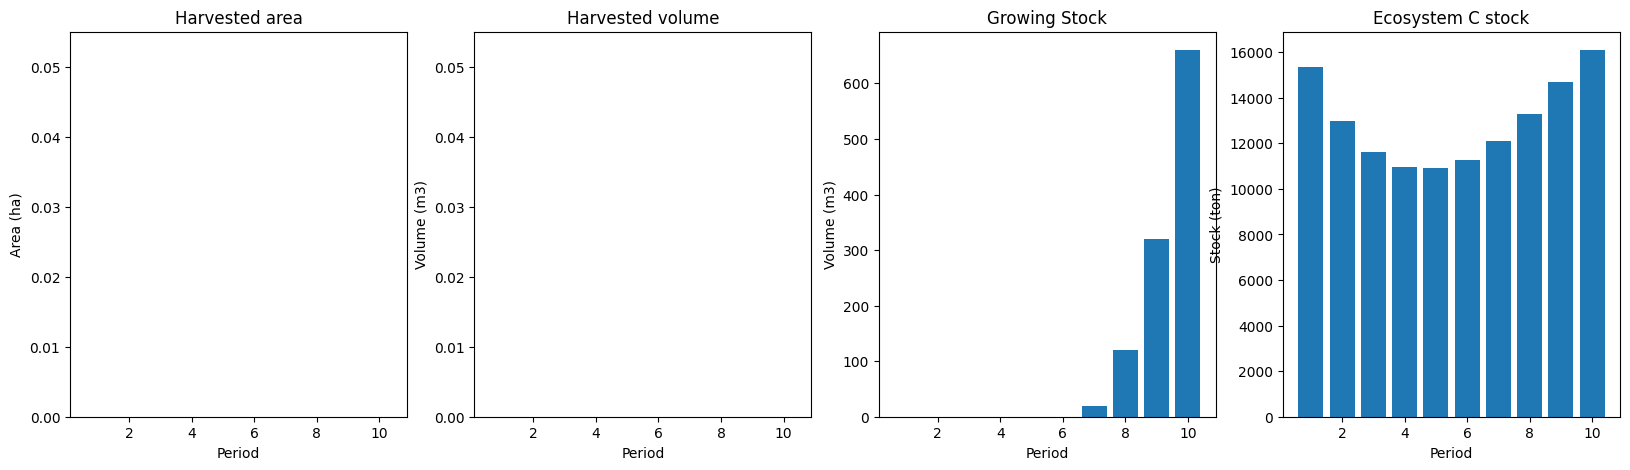

In [39]:
df = compile_scenario_maxstock(fm)
plot_scenario_maxstock(df)

In [40]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm_maxstock(sit_config, sit_tables, n_steps)

,Biomass,DOM,Ecosystem,All_Emissions,Gross_Growth,Stock_Change
Year,,,,,,
0,0.062350,4039.717310,4039.779660,0.000000,0.000000,0.000000
1,0.139657,3952.015168,3952.154825,87.715628,0.090793,87.624835
2,0.269322,3869.896408,3870.165731,82.146062,0.156967,81.989095
3,0.466292,3792.618278,3793.084570,77.327235,0.246074,77.081160
4,0.745499,3719.626400,3720.371899,73.072764,0.360093,72.712671
...,...,...,...,...,...,...
96,1393.729165,2735.824581,4129.553746,76.196707,103.428831,-27.232124
97,1410.587302,2746.343824,4156.931126,76.845526,104.222906,-27.377380
98,1427.773077,2756.718212,4184.491289,77.463155,105.023317,-27.560163


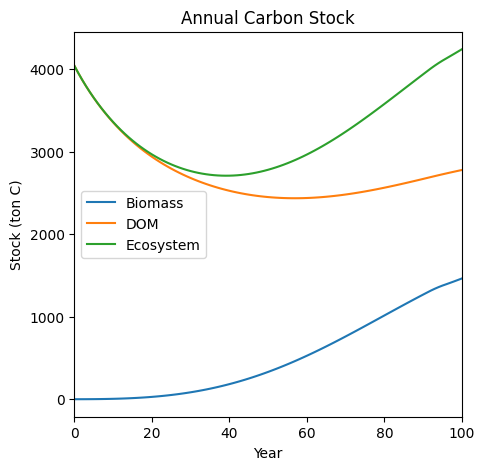

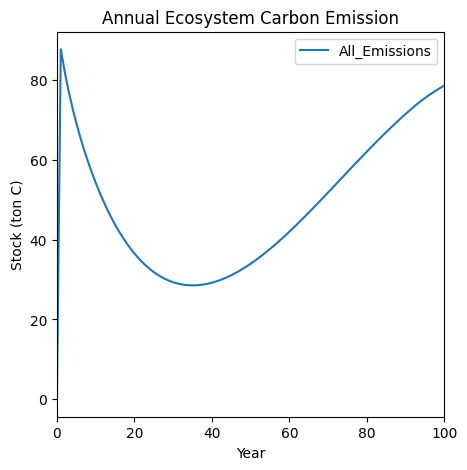

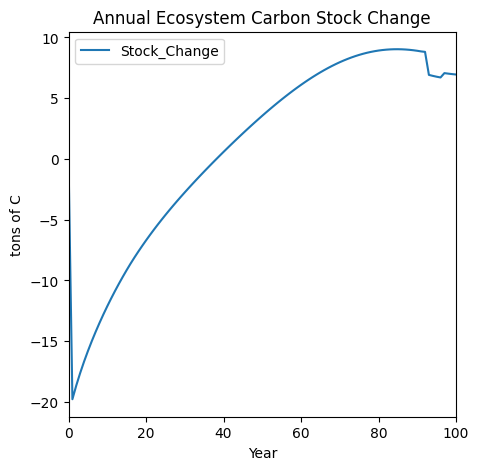

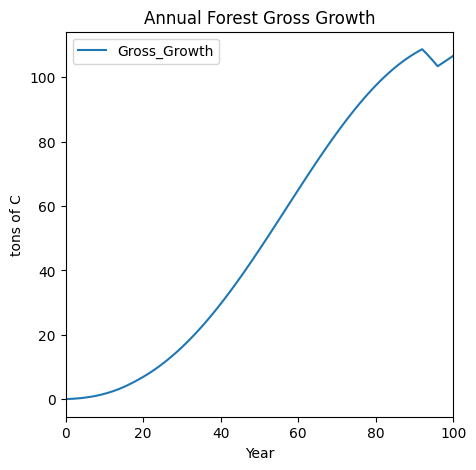

In [41]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)

In [42]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
# compare_ws3_cbm_exactmatch(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, plots="whole")

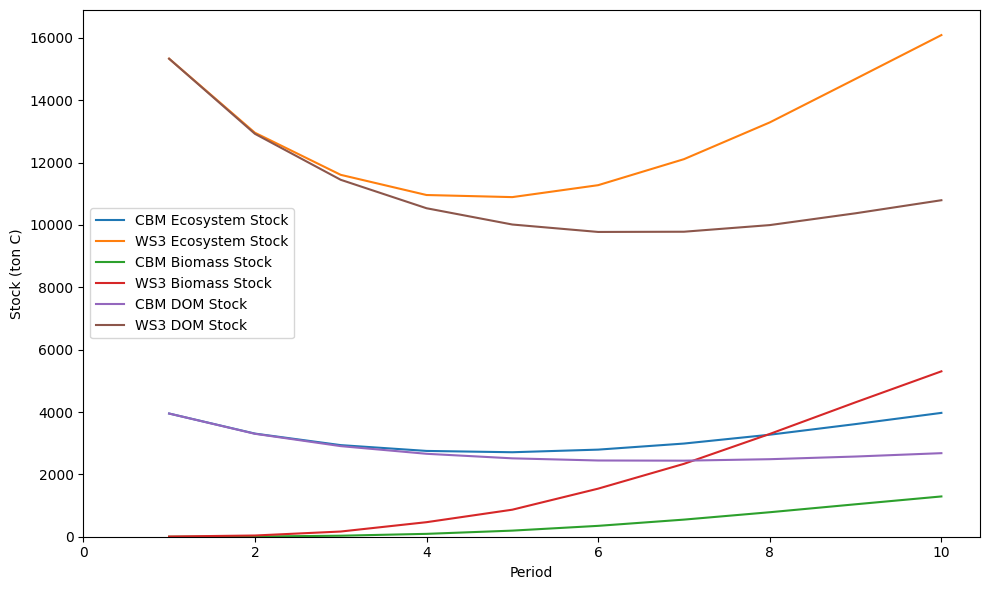

(   period  biomass_stock    dom_stock    eco_stock  eco_stock_change
 0       1       0.139657  3952.015168  3952.154825          0.000000
 1       2       6.251477  3302.051489  3308.302966       -643.851859
 2       3      32.317815  2906.050732  2938.368547       -369.934419
 3       4      91.911315  2660.274302  2752.185618       -186.182930
 4       5     195.622199  2514.450201  2710.072400        -42.113217
 5       6     348.701186  2445.187660  2793.888846         83.816446
 6       7     548.914398  2439.793481  2988.707879        194.819033
 7       8     785.584588  2486.845449  3272.430037        283.722158
 8       9    1040.671614  2572.461414  3613.133028        340.702991
 9      10    1292.128125  2680.437423  3972.565548        359.432520,
    period  biomass_stock     dom_stock     eco_stock  eco_stock_change
 0       1       5.875880  15334.156255  15335.777025          0.000000
 1       2      38.938040  12925.000706  12959.706157      -2376.070868
 2       3   

In [43]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, plots="whole")

In [44]:
print('It took', round((time.time() - Start) / 60, 1), "minutes to run this script.")

It took 0.5 minutes to run this script.
